In [46]:
# ขั้นตอนที่ 1 ติดตั้งไลบรารีที่จำเป็น

In [47]:
!pip install osmnx==1.9.1 folium -q

In [48]:
# ขั้นตอนที่ 2 Import และตั้งค่าพื้นฐาน

In [49]:
import osmnx as ox
import networkx as nx
import folium
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display

In [50]:
ox.settings.use_cache = True
ox.settings.log_console = False

In [51]:
print(f"OSMnx version: {ox.__version__}")
print(f"NetworkX version: {nx.__version__}")

OSMnx version: 1.9.1
NetworkX version: 3.5


In [52]:
# ขั้นตอนที่ 3 ดึงข้อมูลแผนที่กรุงเทพฯ

In [92]:
place_name = "Thailand"

In [ ]:
try:
    # ดึงข้อมูลเครือข่ายถนนสำหรับการขับรถ
    G = ox.graph_from_place(place_name, network_type='drive')

    print(f"- Nodes (intersections): {G.number_of_nodes():,}")
    print(f"- Edges (street segments): {G.number_of_edges():,}")

    fig, ax = ox.plot_graph(G, node_size=5, edge_linewidth=0.5, show=False, close=False)
    plt.title(f"Street Network of {place_name}")
    plt.show()

except Exception as e:
    print(f"Error downloading map data: {e}")

/usr/local/lib/python3.11/dist-packages/osmnx/_overpass.py:211: UserWarning: This area is 434 times your configured Overpass max query area size. It will automatically be divided up into multiple sub-queries accordingly. This may take a long time.
  multi_poly_proj = utils_geo._consolidate_subdivide_geometry(poly_proj)


In [54]:
# ขั้นตอนที่ 4 สำรวจข้อมูลเบื้องต้น

In [55]:
edges = ox.graph_to_gdfs(G, nodes=False)

print("🔍 Sample street data (first 5 streets):")
print(edges[['highway', 'length', 'name']].head())

print("\n📊 Types of roads in our graph:")
highway_counts = edges['highway'].value_counts()
print(highway_counts.head(10))

🔍 Sample street data (first 5 streets):
                              highway   length             name
u         v          key                                       
105835765 105845337  0        primary   15.216  ถนนรัตนาธิเบศร์
          1711172922 0        primary  179.466      ถนนติวานนท์
105845318 8968563189 0        primary   39.027      ถนนติวานนท์
          2662860066 0    residential  224.455    ซอยติวานนท์ 9
105845325 929364563  0        primary   32.189      ถนนติวานนท์

📊 Types of roads in our graph:
highway
residential       124593
tertiary            7510
unclassified        3938
secondary           2489
primary              630
secondary_link       415
primary_link         303
trunk                252
trunk_link           194
motorway_link         80
Name: count, dtype: int64


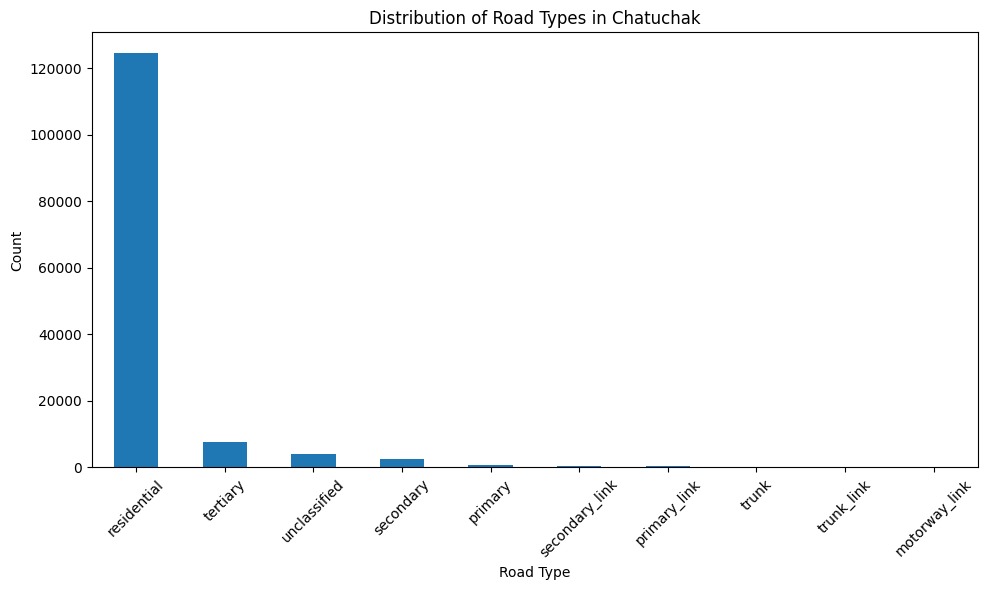

In [56]:
plt.figure(figsize=(10, 6))
highway_counts.head(10).plot(kind='bar')
plt.title("Distribution of Road Types in Chatuchak")
plt.xlabel("Road Type")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [57]:
# ขั้นตอนที่ 5 กำหนดจุดเริ่มต้นและปลายทาง

In [58]:
#start_lat, start_lon = 13.8021, 100.5538
#start_name = "MRT Chatuchak Park"

In [59]:

start_lat, start_lon = 13.876163, 100.382802
start_name = "PERAPAT HOUSE"

In [60]:
#end_lat, end_lon = 13.7992, 100.5489
#end_name = "Or Tor Kor Market"

In [81]:
13.820036, 100.040070
end_lat, end_lon = 13.820036, 100.040070
end_name = "Silpakorn"

In [82]:
#  หาโหนดที่ใกล้ที่สุดบนกราฟ
orig_node = ox.nearest_nodes(G, start_lon, start_lat)
dest_node = ox.nearest_nodes(G, end_lon, end_lat)

print(f"🚶 Starting point: {start_name}")
print(f"   Node ID: {orig_node}")
print(f"🎯 Destination: {end_name}")
print(f"   Node ID: {dest_node}")

🚶 Starting point: PERAPAT HOUSE
   Node ID: 5889760484
🎯 Destination: Silpakorn
   Node ID: 5904949598


In [83]:
if nx.has_path(G, orig_node, dest_node):
    print("Path exists between origin and destination!")
else:
    print("No path found! Try different locations.")

Path exists between origin and destination!


In [64]:
# ขั้นตอนที่ 6 หาเส้นทางที่สั้นที่สุดด้วย A*

In [84]:
try:
    # ใช้ A* algorithm หาเส้นทางที่สั้นที่สุด (ตามระยะทาง)
    shortest_route = nx.astar_path(G, orig_node, dest_node, weight='length')

    # คำนวณระยะทางรวม
    route_length = nx.path_weight(G, shortest_route, weight='length')

    print(f"✅ Shortest route found!")
    print(f"📏 Total distance: {route_length:,.0f} meters ({route_length/1000:.2f} km)")
    print(f"🔢 Number of intersections: {len(shortest_route)}")

except nx.NetworkXNoPath:
    print("❌ No path found between these locations!")
except Exception as e:
    print(f"❌ Error: {e}")

✅ Shortest route found!
📏 Total distance: 18,012 meters (18.01 km)
🔢 Number of intersections: 96


In [66]:
# ขั้นตอนที่ 7 แสดงผลเส้นทางบนแผนที่ Interactive

In [77]:
route_map = ox.plot_route_folium(G, shortest_route,
                                  route_color='red',
                                  route_width=5,
                                  route_opacity=0.8)

/tmp/ipython-input-77-562654551.py:1: FutureWarning: The `folium` module has been deprecated and will be removed in the v2.0.0 release. You can generate and explore interactive web maps of graph nodes, edges, and/or routes automatically using GeoPandas.GeoDataFrame.explore instead, for example like: `ox.graph_to_gdfs(G, nodes=False).explore()`. See the OSMnx examples gallery for complete details and demonstrations.
  route_map = ox.plot_route_folium(G, shortest_route,


In [78]:
start_marker = folium.Marker(
    location=[start_lat, start_lon],
    popup=f"<b>Start:</b> {start_name}",
    icon=folium.Icon(color='green', icon='play')
)
start_marker.add_to(route_map)

end_marker = folium.Marker(
    location=[end_lat, end_lon],
    popup=f"<b>End:</b> {end_name}",
    icon=folium.Icon(color='red', icon='stop')
)
end_marker.add_to(route_map)

In [79]:
print("🗺️ Interactive map (zoom in/out to explore):")
display(route_map)

🗺️ Interactive map (zoom in/out to explore):


In [70]:
# ขั้นตอนที่ 8 วิเคราะห์เส้นทาง

In [80]:
route_edges = ox.utils_graph.route_to_gdf(G, shortest_route, weight='length')

print("📊 Route Analysis:")
print(f"Total segments: {len(route_edges)}")
print(f"\n🛣️ Street names used:")

# รวบรวมชื่อถนนที่ใช้ (ไม่ซ้ำ)
street_names = route_edges['name'].dropna().unique()
for i, street in enumerate(street_names, 1):
    print(f"   {i}. {street}")

# แสดงประเภทถนนที่ใช้
print(f"\n🚗 Road types used:")
road_types = route_edges['highway'].value_counts()
for road_type, count in road_types.items():
    print(f"   - {road_type}: {count} segments")

📊 Route Analysis:
Total segments: 95

🛣️ Street names used:


KeyError: 'name'

In [ ]:
# ขั้นตอนที่ 9 ลองเปลี่ยนจุดปลายทาง

In [ ]:
new_end_lat, new_end_lon = 13.8161, 100.5607
new_end_name = "Central Plaza Ladprao"

print(f"🎯 New destination: {new_end_name}")

In [ ]:
new_dest_node = ox.nearest_nodes(G, new_end_lon, new_end_lat)
new_route = nx.astar_path(G, orig_node, new_dest_node, weight='length')
new_length = nx.path_weight(G, new_route, weight='length')

print(f"📏 Distance to new destination: {new_length:,.0f} meters ({new_length/1000:.2f} km)")
print(f"📊 Difference: {abs(new_length - route_length):,.0f} meters")

In [ ]:
comparison_map = ox.plot_route_folium(G, shortest_route,
                                      route_color='red',
                                      route_width=4,
                                      route_opacity=0.7)

comparison_map = ox.plot_route_folium(G, new_route,
                                      route_map=comparison_map,
                                      route_color='blue',
                                      route_width=4,
                                      route_opacity=0.7)

In [ ]:
folium.Marker([start_lat, start_lon],
              popup=f"<b>Start:</b> {start_name}",
              icon=folium.Icon(color='green')).add_to(comparison_map)

folium.Marker([end_lat, end_lon],
              popup=f"<b>Destination 1:</b> {end_name}",
              icon=folium.Icon(color='red')).add_to(comparison_map)

folium.Marker([new_end_lat, new_end_lon],
              popup=f"<b>Destination 2:</b> {new_end_name}",
              icon=folium.Icon(color='blue')).add_to(comparison_map)

print("\n🗺️ Comparison map (Red = Or Tor Kor, Blue = Central Ladprao):")
display(comparison_map)

In [ ]:
help(ox.graph_from_place)

In [ ]:
# ขั้นตอนที่ 10 เพิ่ม "travel time" เป็น weight แทน distance

In [ ]:
# Define estimated travel speeds for different road types in km/h
speed_kmph = {
    'residential': 30,  # Typical speed in residential areas
    'unclassified': 30, # Similar to residential
    'tertiary': 40,     # Medium speed urban roads
    'secondary': 50,    # Arterial roads
    'primary': 60,      # Major urban roads
    'trunk': 70,        # Major highways/expressways within urban area
    'motorway': 90,     # High-speed expressways
    'living_street': 10,# Very low speed
    'service': 20,      # Service roads, alleys
    'road': 30,         # General unclassified roads
    'primary_link': 60, # Links to primary roads
    'secondary_link': 50,# Links to secondary roads
    'tertiary_link': 40, # Links to tertiary roads
    'trunk_link': 70,   # Links to trunk roads
    'motorway_link': 90 # Links to motorways
}

print("Estimated speeds (km/h) by road type")
for highway_type, speed in speed_kmph.items():
    print(f"  {highway_type}: {speed}")

In [ ]:
# ขั้นตอนที่ 11 คำนวน travel time

In [ ]:
# Convert speed from km/h to meters per second
speed_mps = {highway_type: speed * 1000 / 3600 for highway_type, speed in speed_kmph.items()}

# Add 'speed_mps' attribute to edges based on 'highway' type
G = ox.add_edge_speeds(G, speed_mps)

# Calculate and add 'travel_time' attribute to edges
G = ox.add_edge_travel_times(G)

In [ ]:
# ขั้นตอนที่ 12 shortest path จาก time

In [ ]:
# ใช้ A* algorithm หาเส้นทางที่ใช้เวลาน้อยที่สุด
shortest_route_time = nx.astar_path(G, orig_node, dest_node, weight='travel_time')

# คำนวณเวลาการเดินทางรวม
route_time = nx.path_weight(G, shortest_route_time, weight='travel_time')

print(f"⏰ Estimated total travel time: {route_time:.2f} seconds ({route_time/60:.2f} minutes)")
print(f"Number of intersections: {len(shortest_route_time)}")

In [ ]:
# ตัวอย่างการกำหนดความเร็วให้แต่ละเส้นทาง

In [ ]:
# u, v, key คือตัวระบุเส้นถนน และ 'speed_mps_actual' คือความเร็วจริงในหน่วย เมตรต่อวินาที
data = {
    'u': [85753778, 105838415, 105838415, 9444510080, 2197616325],
    'v': [1893839406, 1817818994, 8107214608, 2197616325, 9444510080],
    'key': [0, 0, 0, 0, 0],
    'speed_mps_actual': [15.2, 12.5, 5.0, 10.0, 9.5]
}

df_speeds_actual = pd.DataFrame(data)

display(df_speeds_actual)